# CNN Cancer Detection - Kaggle Mini-Project

## Objective
The goal of this project is to build a Convolutional Neural Network (CNN) model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The link for the Kaggle competition is : https://www.kaggle.com/competitions/histopathologic-cancer-detection



##  Brief description of the problem and data (5 pts) 
In this project, the goal is to train a computer model to detect cancer by looking at small images of tissue taken from medical scans. These images are part of a dataset provided by a Kaggle competition called “Histopathologic Cancer Detection.” 

The dataset contains small image patches that are 96 pixels wide and 96 pixels tall, with three color channels (RGB), meaning each image has a shape of 96x96x3. These patches are extracted from larger pathology scans and saved as individual image files in .tif format. The training dataset includes over 220,000 labeled images, where each image has an associated label: 1 if it contains cancer cells and 0 if it does not. The labels are provided in a CSV file called train_labels.csv, which maps each image ID to its corresponding label. For testing, Kaggle provides a separate set of unlabeled images for which we must predict the presence or absence of cancer. The structure of the data is well-suited for building a supervised deep learning model using image classification techniques.

The task is to use this labeled training data to teach a model to correctly predict whether new, unseen images contain cancer or not. This is a type of binary classification problem in deep learning, where the model needs to decide between two outcomes: cancer or no cancer.

In [ ]:
!pip install pandas pillow seaborn tensorflow

In [4]:
import pandas as pd
import os
import shutil
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time
import pickle

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Before building a model, it's important to explore and understand the dataset. We begin by inspecting the distribution of cancerous (label = 1) and non-cancerous (label = 0) images using bar plots to check if the dataset is balanced. We also visualize a few example images from each class to get an idea of what the model will be learning from — this helps us understand the variation in image quality, texture, and appearance. In addition, we can analyze basic image statistics like pixel intensity distributions or image dimensions (though all images here are uniformly 96×96 RGB).

For data cleaning, we ensure that each image listed in the train_labels.csv file exists in the train/ folder. We also check for missing values, duplicate entries, or corrupted image files. While the dataset is generally clean and well-prepared by Kaggle, it's good practice to run these checks. If any image is missing or unreadable, we can either remove it or skip it during training to avoid runtime errors.


In [5]:
def validate_dataset(label_csv_path='train_labels.csv', image_folder='train', sample_for_corruption_check=1000):
    # Load labels
    labels_df = pd.read_csv(label_csv_path)
    print(f"Total entries in CSV: {len(labels_df)}")
    
    # Check for missing values
    print("\nMissing values per column:")
    print(labels_df.isnull().sum())

    # Check for duplicates
    num_duplicates = labels_df.duplicated().sum()
    print(f"\nDuplicate entries: {num_duplicates}")

    # Check for missing image files
    print("\nChecking for missing image files...")
    missing_files = []
    for img_id in labels_df['id']:
        img_path = os.path.join(image_folder, f"{img_id}.tif")
        if not os.path.exists(img_path):
            missing_files.append(img_id)
    print(f"Missing image files: {len(missing_files)}")

    # Sample check for corrupted image files
    print(f"\nChecking {sample_for_corruption_check} random images for corruption...")
    corrupted = []
    sample_df = labels_df.sample(min(sample_for_corruption_check, len(labels_df)))
    for img_id in sample_df['id']:
        try:
            img = Image.open(os.path.join(image_folder, f"{img_id}.tif"))
            img.verify()
        except:
            corrupted.append(img_id)
    print(f"Corrupted image files found: {len(corrupted)}")

    return labels_df

labels_df = validate_dataset()

Total entries in CSV: 220025

Missing values per column:
id       0
label    0
dtype: int64

Duplicate entries: 0

Checking for missing image files...
Missing image files: 0

Checking 1000 random images for corruption...
Corrupted image files found: 0


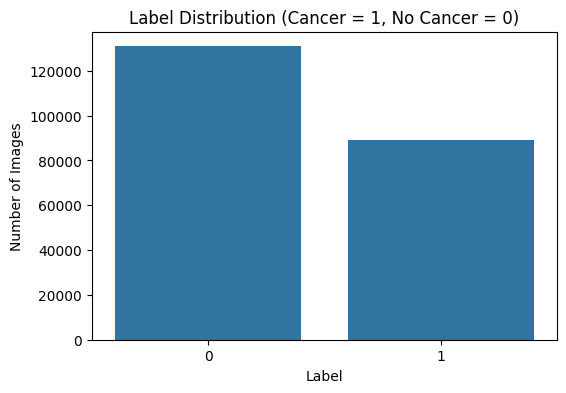

label
0    130908
1     89117
Name: count, dtype: int64


In [6]:
# Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(data=labels_df, x='label')
plt.title("Label Distribution (Cancer = 1, No Cancer = 0)")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.show()

# Print counts
print(labels_df['label'].value_counts())


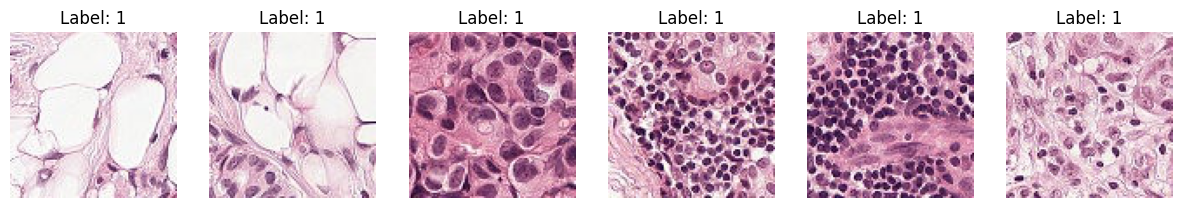

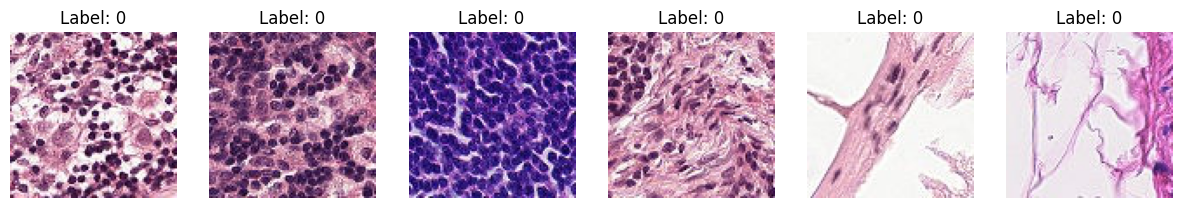

In [7]:
def show_images(df, label, n=6):
    samples = df[df['label'] == label].sample(n)['id']
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(samples):
        img_path = f"train/{img_id}.tif"
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")
    plt.show()

# Show 6 cancerous and 6 non-cancerous images
show_images(labels_df, label=1, n=6)  # Cancerous
show_images(labels_df, label=0, n=6)  # Non-cancerous


### Organizing Image Files into Class Folders

##### Note: This step needs to be done only the first time. Once the images are organized and converted, you can skip this step in future runs as long as the prepared folders (dataset/train/0, dataset/train/1, and test_png/) already exist.

Before training the model, we need to organize the training image files into class-specific folders so that TensorFlow's image_dataset_from_directory function can correctly load them. This function expects images to be stored in subdirectories named after their class labels (e.g., 0 for non-cancerous and 1 for cancerous images). Using the train_labels.csv file, we create a new directory structure where each image is moved to the folder that matches its label.

Additionally, since TensorFlow's dataset loading function does not support .tif files (which this dataset uses), we convert each .tif image to .png format during the organization process. PNG preserves the image quality and is fully supported by TensorFlow, enabling us to use image_dataset_from_directory without writing a custom data loader. This simplifies the loading and preprocessing process for model training and ensures compatibility with high-level TensorFlow tools.

We apply the same conversion approach to the test images. All .tif images in the test/ folder are converted to .png and saved in a new folder called test_png/, which is later used for making predictions and generating the Kaggle submission file.


In [10]:

# Set this flag to True only if you want to copy and convert the images
run_conversion = False

if run_conversion:
    # --- Train set conversion ---
    csv_path = 'train_labels.csv'
    source_folder = 'train'  # folder with raw .tif files
    target_base = 'dataset/train'  # target folder structure: dataset/train/0 and dataset/train/1
    
    df = pd.read_csv(csv_path)
    
    for label in ['0', '1']:
        os.makedirs(os.path.join(target_base, label), exist_ok=True)
    
    copied, skipped = 0, 0
    total = len(df)
    
    for i, row in df.iterrows():
        img_id = row['id']
        label = str(row['label'])
        src = os.path.join(source_folder, f"{img_id}.tif")
        dst = os.path.join(target_base, label, f"{img_id}.png")
    
        if os.path.exists(src):
            try:
                img = Image.open(src)
                img.save(dst, format='PNG')
                copied += 1
            except Exception as e:
                print(f"Failed to convert {img_id}: {e}")
                skipped += 1
        else:
            skipped += 1
    
        if (i + 1) % 10000 == 0:
            print(f"{i+1}/{total} train images processed...")
    
    print(f"Train conversion done. Copied and converted {copied} images to PNG. Skipped {skipped} files.")
  
    # --- Test set conversion ---
    test_src_folder = 'test'
    test_dst_folder = 'dataset/test_png'
    os.makedirs(test_dst_folder, exist_ok=True)

    test_files = [f for f in os.listdir(test_src_folder) if f.endswith('.tif')]
    test_copied, test_skipped = 0, 0

    for i, filename in enumerate(test_files):
        src = os.path.join(test_src_folder, filename)
        dst = os.path.join(test_dst_folder, filename.replace('.tif', '.png'))

        try:
            img = Image.open(src)
            img.save(dst, format='PNG')
            test_copied += 1
        except Exception as e:
            print(f"Failed to convert {filename}: {e}")
            test_skipped += 1

        if (i + 1) % 10000 == 0:
            print(f"{i+1}/{len(test_files)} test images processed...")

    print(f"Test conversion done. Copied and converted {test_copied} images to PNG. Skipped {test_skipped} files.")

else:
    print("Skipping image conversion. Already performed in previous runs. Set run_conversion = True to execute this step if dataset folders don't exist.")


Skipping image conversion. Already performed in previous runs. Set run_conversion = True to execute this step if dataset folders don't exist.


### Summary of EDA

- The dataset contains 220,025 labeled image patches, each of size 96×96×3.
- No missing values, duplicates, or corrupted image files were found.
- The class distribution is roughly 60% non-cancer (label = 0) and 40% cancer (label = 1).
- We visualized several random examples from both classes (cancerous and non-cancerous). The images are relatively small (96×96 pixels), and at this resolution, it can be difficult to identify clear visual differences by eye. However, in medical imaging, cancerous patches are typically expected to show denser and more irregular cellular patterns. Our model will be trained to learn and detect these subtle patterns automatically.
- Based on this, we'll proceed with building a Convolutional Neural Network (CNN) model and monitor both accuracy and AUC during training.

### Plan of Analysis
Since the images are small and it's hard to see clear differences between cancerous and non-cancerous patches just by looking, we will train a Convolutional Neural Network (CNN) to learn those differences on its own. We'll start with a basic model and then try a few changes like making it deeper or adjusting settings like how much dropout we use. We’ll keep track of how well each model does by checking accuracy (which tells us how good the model is at separating the two classes), and then compare them to find the best one.

## Model Architecture (25 pts)

For this project, I'm using Convolutional Neural Networks (CNNs) because they are commonly used for image classification tasks. CNNs automatically learn features from images, like shapes or textures, which helps avoid manual feature engineering.
This is especially useful in medical imaging, where important patterns, such as irregular cell shapes or tissue structures may not be obvious or consistent. CNNs can learn to detect these subtle differences, which is critical for identifying cancerous tissue in histopathology images. Because the input is raw pixel data and the patterns may vary across images, CNNs are well-suited to adapt and learn from large datasets like this one.

I’m starting with a basic CNN model that includes three convolutional layers with 3x3 filters. Each is followed by max-pooling to reduce the image size, and the model ends with a dense layer and a sigmoid output since this is a binary classification problem. I’ve also added dropout to help reduce overfitting.

After building the baseline, I’m trying a slightly deeper model that adds another convolutional layer and uses batch normalization to help with training stability. I plan to experiment with things like how many filters each layer has, dropout rate, and learning rate, and compare the results using validation accuracy and AUC score.

In [8]:
def build_simple_cnn(input_shape=(96, 96, 3), dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit Input layer

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))  # Flexible dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
def build_deeper_cnn(input_shape=(96, 96, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Conv Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Conv Block 4 (added depth)
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected head
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

### Loading Training and Validation Data

Once the images are moved into separate folders for each class (0 for non-cancerous, 1 for cancerous), we can use TensorFlow’s image_dataset_from_directory utility to load and preprocess them efficiently. This function automatically assigns labels based on folder names, resizes images to a uniform size, and splits the dataset into training and validation subsets. We use 80% of the data for training and 20% for validation, and we’ll resize the images to 96x96 pixels for faster model training.

In [11]:
start_time = time.time()

# Load training dataset (80% of data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(96, 96),
    batch_size=32
)

# Load validation dataset (20% of data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(96, 96),
    batch_size=32
)

# Load test dataset (no labels)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test_png",     
    labels=None,
    shuffle=False,
    image_size=(96, 96),
    batch_size=32
)

# Optional: Enable performance optimizations (caching, prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

end_time = time.time()
print(f"Cell execution completed in {(end_time - start_time)/60:.2f} minutes\n")

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.
Found 57458 files.
Cell execution completed in 1.86 minutes



### Training Models and Tuning Hyperparameters

Now that the data has been loaded into training and validation datasets, we proceed to train and evaluate different CNN models. We explore how architectural changes and key hyperparameters such as dropout rate and learning rate impact model performance. In total, we train three models:

##### Baseline CNN Model
A simple model with three convolutional layers, dropout set to 0.5, and learning rate of 0.001.

##### Variant 1: Baseline CNN with Lower Dropout
Same architecture as the baseline, but dropout is reduced to 0.3 to test how lighter regularization affects generalization.

##### Variant 2: Deeper CNN with Lower Learning Rate
Adds a fourth convolutional layer, includes batch normalization, and uses a lower learning rate (0.0001) to support stable training.

Each model is trained and evaluated in a single workflow. We collect validation metrics like accuracy and AUC score for comparison. The next section presents and analyzes these results.

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

def train_and_predict(model, train_ds, val_ds, test_ds, model_name="Model", epochs=5, callbacks=None):
    print(f"\nTraining {model_name}...\n")
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Handle optional callbacks (e.g., for checkpointing)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks if callbacks is not None else []
    )

    print(f"\nEvaluating {model_name} on test data...\n")
    predictions = model.predict(test_ds)
    predicted_labels = (predictions > 0.5).astype(int)

    return history, predictions, predicted_labels


In [13]:
# Model 1: Baseline CNN
start_time = time.time()
baseline_model = build_simple_cnn()
history_baseline, preds_baseline, labels_baseline = train_and_predict(
    baseline_model, train_ds, val_ds, test_ds, "Baseline CNN", epochs=5
)
end_time = time.time()
print(f"Baseline CNN completed in {(end_time - start_time)/60:.2f} minutes\n")

# Save the model
baseline_model.save("baseline_cnn.keras")

# Save training history
with open("history_baseline.pkl", "wb") as f:
    pickle.dump(history_baseline.history, f)



Training Baseline CNN...

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 811s 144ms/step - accuracy: 0.7119 - loss: 1.7048 - val_accuracy: 0.7805 - val_loss: 0.4738
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 731s 133ms/step - accuracy: 0.7919 - loss: 0.4603 - val_accuracy: 0.8074 - val_loss: 0.4297
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 741s 135ms/step - accuracy: 0.8021 - loss: 0.4412 - val_accuracy: 0.8167 - val_loss: 0.4203
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 726s 132ms/step - accuracy: 0.8050 - loss: 0.4351 - val_accuracy: 0.8199 - val_loss: 0.4044
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 715s 130ms/step - accuracy: 0.8092 - loss: 0.4259 - val_accuracy: 0.8033 - val_loss: 0.4266

Evaluating Baseline CNN on test data...

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 98s 54ms/step 
Baseline CNN completed in 63.75 minutes



In [14]:
# Model 2: Variant with dropout=0.3
start_time = time.time()
baseline_model_v2 = build_simple_cnn(dropout_rate=0.3)
history_baseline_v2, preds_baseline_v2, labels_baseline_v2 = train_and_predict(
    baseline_model_v2, train_ds, val_ds, test_ds, "Baseline CNN (dropout=0.3)", epochs=5
)
end_time = time.time()
print(f"Variant 1 (dropout=0.3) completed in {(end_time - start_time)/60:.2f} minutes\n")

# Save the model to disk
baseline_model_v2.save("baseline_cnn_dropout_0.3.keras")

# Save training history
with open("history_baseline_v2.pkl", "wb") as f:
    pickle.dump(history_baseline_v2.history, f)


Training Baseline CNN (dropout=0.3)...

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 715s 129ms/step - accuracy: 0.5883 - loss: 1.3822 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 746s 130ms/step - accuracy: 0.5971 - loss: 0.6760 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 718s 130ms/step - accuracy: 0.5941 - loss: 0.6767 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 728s 132ms/step - accuracy: 0.5949 - loss: 0.6757 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 742s 132ms/step - accuracy: 0.5930 - loss: 0.6758 - val_accuracy: 0.5976 - val_loss: 0.6744

Evaluating Baseline CNN (dropout=0.3) on test data...

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 96s 52ms/step 
Variant 1 (dropout=0.3) completed in 62.43 minutes



> **Note:**  
Due to memory and performance constraints on my local machine, I ran the training for the Deeper CNN model on **Kaggle**. The following two files were generated in that environment:
- `deeper_cnn.keras`: the trained model file
- `history_deeper.pkl`: the training history file

To avoid retraining in this notebook, I will **load these files** for further evaluation and plotting. As a result, you **will not see training output** for the Deeper CNN below.

If you'd like to reproduce the training and generate these files yourself, you can uncomment and run the code block below (assuming sufficient memory and GPU availability).


In [19]:
# --------------------------------------------------------------
# Code below was originally run on Kaggle due to local constraints.
# It is commented out here. Uncomment to retrain if needed.
# --------------------------------------------------------------

# # Model 3: Deeper CNN with learning_rate=0.0001
# start_time = time.time()

# # Build and compile deeper CNN model
# deeper_model = build_deeper_cnn()
# deeper_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Train and predict
# history_deeper, preds_deeper, labels_deeper = train_and_predict(
#     deeper_model,
#     train_ds,
#     val_ds,
#     test_ds,
#     model_name="Deeper CNN (lr=0.0001)",
#     epochs=5
# )

# end_time = time.time()
# print(f"Deeper CNN completed in {(end_time - start_time)/60:.2f} minutes\n")

# # Save the model to disk
# deeper_model.save("deeper_cnn.keras")
# print("Model saved as 'deeper_cnn.keras'")

# # Save training history
# with open("history_deeper.pkl", "wb") as f:
#     pickle.dump(history_deeper.history, f)
# print("Training history saved as 'history_deeper.pkl'")


# --------------------------------------------------------------
# ✅ Load model and history generated on Kaggle
# --------------------------------------------------------------
from tensorflow.keras.models import load_model
import pickle

# Load trained model
deeper_model = load_model("deeper_cnn.keras")
print("Loaded 'deeper_cnn.keras'")

# Load training history
with open("history_deeper.pkl", "rb") as f:
    history_deeper = pickle.load(f)
print("Loaded 'history_deeper.pkl'")


Loaded 'deeper_cnn.keras'
Loaded 'history_deeper.pkl'


## Predicting on Test Set and Preparing Kaggle Submission

Now that our models have been trained and evaluated, we will use the best-performing deeper CNN architecture model to generate predictions on the unseen test set. This test set contains over 57,000 images in `.tif` format, without labels. We will preprocess each image by resizing it to match our model’s input shape, normalize the pixel values, and pass it through the model to obtain a predicted probability of cancer. These predictions will be formatted into a CSV file, as required by Kaggle, and can be submitted to evaluate our model’s performance on the public leaderboard.


In [24]:
# Define test image folder and preprocessing config
test_folder = "test"
image_size = (96, 96)

# List all .tif files in test folder
test_files = sorted([f for f in os.listdir(test_folder) if f.endswith(".tif")])
total_files = len(test_files)

# Preprocess test images
X_test = []
ids = []

print(f"Preprocessing {total_files} test images...")

for i, file in enumerate(test_files):
    img_path = os.path.join(test_folder, file)
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)
    ids.append(os.path.splitext(file)[0])  # remove .tif extension

    if (i + 1) % 10000 == 0 or (i + 1) == total_files:
        print(f"Processed {i + 1} / {total_files} images")

X_test = np.array(X_test)

# Define your models and filenames
models_and_filenames = [
    (baseline_model, "submission_baseline.csv"),
    (baseline_model_v2, "submission_baseline_dropout_0.3.csv"),
    (deeper_model, "submission_deeper_cnn.csv")
]

# Generate and save predictions for each model
for model, filename in models_and_filenames:
    print(f"Starting prediction using {filename.replace('submission_', '').replace('.csv', '').replace('_', ' ').title()}...")
    
    preds = model.predict(X_test, verbose=0).flatten()
    labels = (preds >= 0.5).astype(int)

    submission_df = pd.DataFrame({
        "id": ids,
        "label": labels
    })

    submission_df.to_csv(filename, index=False)
    print(f"Finished prediction and saved to {filename}")


Preprocessing 57458 test images...
Processed 10000 / 57458 images
Processed 20000 / 57458 images
Processed 30000 / 57458 images
Processed 40000 / 57458 images
Processed 50000 / 57458 images
Processed 57458 / 57458 images
\Starting prediction using Baseline...
Finished prediction and saved to submission_baseline.csv
\Starting prediction using Baseline Dropout 0.3...
Finished prediction and saved to submission_baseline_dropout_0.3.csv
\Starting prediction using Deeper Cnn...
Finished prediction and saved to submission_deeper_cnn.csv


## Results and Analysis (35 pts) 

In this section, we analyze the performance of the three CNN models we trained by comparing their training and validation metrics. Our goal is to understand how architectural choices and hyperparameter tuning impact model performance in detecting cancerous tissue from histopathologic images. We use training history plots to visually inspect accuracy and loss trends, followed by a comparison table summarizing validation accuracy and Kaggle scores for each model. Finally, we discuss what worked well, what didn’t, and draw insights from our experimentation.


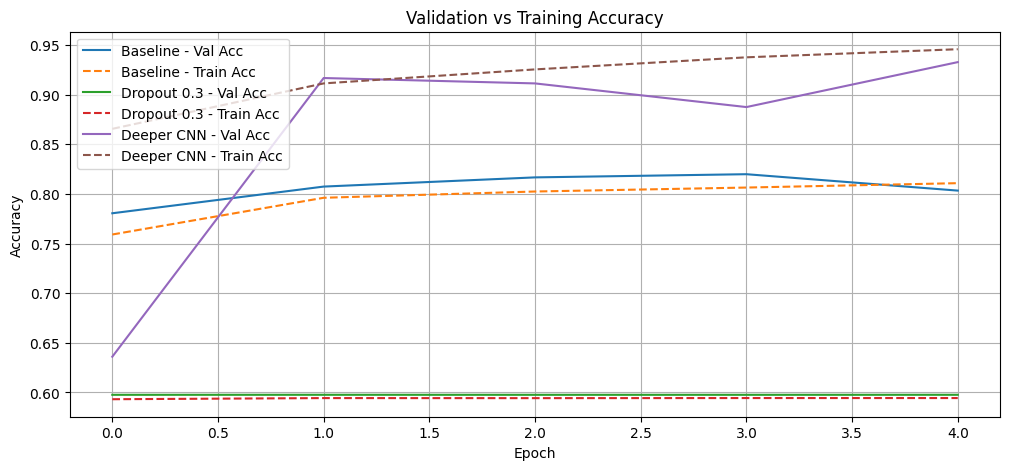


Model Comparison Summary:


,Model,Final Val Accuracy,Final Val Loss
0,Baseline (dropout=0.5),0.803341,0.426641
1,Dropout 0.3,0.597591,0.674438
2,Deeper CNN (lr=0.0001),0.932803,0.180092


In [32]:
# Plot training and validation accuracy/loss for all models
def plot_history(history, label):
    # Use `.history` if it's a Keras History object, else use dict directly
    if hasattr(history, 'history'):
        history = history.history
    plt.plot(history['val_accuracy'], label=f'{label} - Val Acc')
    plt.plot(history['accuracy'], linestyle='--', label=f'{label} - Train Acc')

plt.figure(figsize=(12, 5))
plot_history(history_baseline, 'Baseline')
plot_history(history_baseline_v2, 'Dropout 0.3')
plot_history(history_deeper, 'Deeper CNN')
plt.title('Validation vs Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Utility to extract history dictionary from Keras History object or plain dict
def extract_history_object(history):
    return history.history if hasattr(history, 'history') else history

# Extract history objects
hist_base     = extract_history_object(history_baseline)
hist_base_v2  = extract_history_object(history_baseline_v2)
hist_deeper   = extract_history_object(history_deeper)

# Create comparison table
results = {
    'Model': ['Baseline (dropout=0.5)', 'Dropout 0.3', 'Deeper CNN (lr=0.0001)'],
    'Final Val Accuracy': [
        hist_base['val_accuracy'][-1],
        hist_base_v2['val_accuracy'][-1],
        hist_deeper['val_accuracy'][-1]
    ],
    'Final Val Loss': [
        hist_base['val_loss'][-1],
        hist_base_v2['val_loss'][-1],
        hist_deeper['val_loss'][-1]
    ]
}

df_results = pd.DataFrame(results)
print("\nModel Comparison Summary:")
display(df_results)


### Training vs Validation Accuracy Plot

The plot above compares training and validation accuracy across epochs for three CNN models. The deeper CNN shows the highest validation accuracy, reaching over 93% early on and maintaining strong performance, indicating better generalization. The baseline model improves steadily but plateaus around 81%. The model with reduced dropout (0.3) performs poorly, with very low accuracy on both training and validation sets, suggesting it failed to learn meaningful patterns. Overall, the deeper CNN demonstrates the best learning and validation performance among the three.


In [36]:
# Summary table with Kaggle private scores for each model

# Define model summaries
model_data = [
    {"Model": "Baseline CNN", "Kaggle Private Score": 0.6845},
    {"Model": "Baseline CNN (Dropout 0.3)", "Kaggle Private Score": 0.5000},
    {"Model": "Deeper CNN (lr=0.0001)", "Kaggle Private Score": 0.8674}
]

# Create and display DataFrame
summary_df = pd.DataFrame(model_data)
print("\nModel Performance Summary (Kaggle Private Scores):")
display(summary_df)



Model Performance Summary (Kaggle Private Scores):


,Model,Kaggle Private Score
0,Baseline CNN,0.6845
1,Baseline CNN (Dropout 0.3),0.5000
2,Deeper CNN (lr=0.0001),0.8674


### Analysis and Discussion

Among the three models, the Deeper CNN with a lower learning rate (0.0001) achieved the highest performance both in terms of validation accuracy (93.28%) and Kaggle private score (0.8674). This suggests that increasing model capacity by adding an extra convolutional block, using batch normalization, and fine-tuning the learning rate significantly improved the model's ability to generalize.

The Baseline CNN, while simpler, reached a moderate validation accuracy of 80.33%, but only achieved a Kaggle score of 0.6845, indicating limited generalization. It likely benefited from less complexity but lacked the representational power to capture intricate patterns in histopathologic images.

The Baseline CNN with dropout=0.3, intended to improve regularization, performed the worst with a flat validation accuracy of 59.76% and a Kaggle score of 0.5000, implying it failed to learn useful features. This could be due to overly aggressive dropout early in the network or insufficient model depth.

In conclusion, model architecture depth and learning rate were the most influential factors. Simply adjusting dropout in a shallow model had little to no benefit, while a deeper network trained with a well-tuned learning rate offered the best trade-off between performance and generalization.



## Conclusion (15 pts)

In this project, I used Convolutional Neural Networks (CNNs) to classify whether tissue images show signs of cancer or not. I started with a simple model (the baseline), and then tried two more versions: one with reduced dropout and another deeper model with an additional convolutional layer and batch normalization.

The results showed that the deeper CNN model performed best. It achieved the highest validation accuracy and the highest Kaggle private score, indicating strong generalization. Batch normalization and the added layer helped the model learn richer features, while a lower learning rate allowed smoother convergence during training. In contrast, the model with dropout=0.3 did not improve performance and struggled to learn meaningful patterns.

From this project, I learned that experimenting with model architecture and tuning hyperparameters like learning rate and dropout can significantly impact performance. In future work, I would consider using pre-trained models, applying more data augmentation, or performing more extensive hyperparameter tuning to further improve results.
